In [2]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from datetime import date
from tqdm import tqdm

sys.path.append('../')
from model.gr4j_np import GR4J

In [4]:
np.random.seed(42)
%matplotlib inline
%load_ext autoreload

In [6]:
data_location = os.path.join('/data')

In [7]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2000

# Holdout period
holdout_start_year = 2000
holdout_end_year = 2005

In [8]:
# Load the data
maulescreek_rain_et = pd.read_csv(
    os.path.join(
        data_location,
        'SILO(-30.5,150.1)',
        'FAO56_Penman_Monteith_1989.csv'
    )
)
maulescreek_streamflow = pd.read_csv(
    os.path.join(
        data_location,
        'water_level',
        'bom_gauge_daily_mean_419051.csv'
    )
)

# fix dates 
maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

In [9]:
# 
merged_data = pd.merge(
    maulescreek_rain_et,
    maulescreek_streamflow,
    left_on='Date',
    right_on='Date'
)

# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['Date']).dt.year >= calib_start_year) & ((merged_data['Date']).dt.year < calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['Date']).dt.year >= holdout_start_year) & ((merged_data['Date']).dt.year < holdout_end_year)].reset_index(drop=True)

In [10]:
# Tune GR4J parameters
prcp_calib = calibration_data.loc[:, 'Rain'].values
etp_calib = calibration_data.loc[:, 'FAO56'].values
flow_calib = calibration_data.loc[:, 'Value'].values
date_calib = calibration_data.loc[:, 'Date'].values

In [37]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def normalize(x):
    return 1/(2 - x)

In [12]:
class MCMC:

    def generate_sample(self, theta_c):
        raise("Implement in the subclass!")
    
    def run_sampling(self, N=1000):
        # Initialize samples
        samples = np.zeros((N, self.dim))

        # First sample
        samples[0] = self.init_params()

        # Count of accepted samples
        N_accepted = 0

        pbar = tqdm(range(N-1))

        # Start sampling
        for n in pbar:
            
            # Generate proposal
            theta_c = samples[n]
            samples[n + 1], score, accepted = self.generate_sample(theta_c)

            if accepted:
                N_accepted += 1

            
            pbar.set_description(f'Accepted: {N_accepted/(n+1):.2f} Score: {score:.2f}')
            
        
        print(f"Acceptance ratio: {N_accepted/N:.2f}")
        
        return samples, N_accepted

    def plot_samples(self, samples):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.grid(alpha = 0.2)
        ax.hist(samples, bins=50, alpha=0.6, density=True)
        ax.set_title("Sampled Distribution")
        return ax


In [13]:
class Parameter(object):

    def __init__(self, name, dist):
        self.name = name
        self.dist = dist

    def logpdf(self, x):
        return self.dist.logpdf(x)


class RWGR4J(MCMC):
    def __init__(self, epsilon=[10, 0.1, 10, 0.1, 0.1]):
        self.epsilon = epsilon
        self.gr4j = GR4J()
        self.prcp = prcp_calib
        self.etp = etp_calib
        self.flow = flow_calib
        self.dim=5

        self.params = {
            'x1': Parameter('x1', stats.norm(loc=100, scale=10)),
            'x2': Parameter('x2', stats.norm(loc=0, scale=5)),
            'x3': Parameter('x3', stats.norm(loc=0, scale=5)),
            'x4': Parameter('x4', stats.invgamma(a=0.5, loc=1, scale=1)),
            'tau': Parameter('tau', stats.expon())
        }
    
    def init_params(self):
        theta_0 = []
        for n, p in self.params.items():
            theta_0.append(p.dist.rvs(1)[0])

        self.gr4j.update_params(*theta_0[:-1])
        theta_0[-1] = np.var(self.gr4j.run(self.prcp, self.etp)[0] - self.flow)
        
        return np.array(theta_0)
    
    def log_prior(self, x1, x2, x3, x4, tau):
        p1 = self.params['x1'].logpdf(x1)
        p2 = self.params['x2'].logpdf(x2)
        p3 = self.params['x3'].logpdf(x3)
        p4 = self.params['x4'].logpdf(x4)
        ptau = self.params['tau'].logpdf(tau)
        return p1 + p2 + p3 + p4 + ptau


    def log_gauss_likelihood(self, pred, target, tau):
        return stats.norm.logpdf(pred, loc=target, scale=tau)
    
    def generate_sample(self, theta_c):
        
        # Proposal
        n = np.random.randn(5)
        theta_p = theta_c + self.epsilon * n

        # GR4J
        self.gr4j.update_params(*theta_c[:-1])
        flow_c = self.gr4j.run(self.prcp, self.etp)[0]
        self.gr4j.update_params(*theta_p[:-1])
        flow_p = self.gr4j.run(self.prcp, self.etp)[0]

        # Evaluate acceptance prob
        log_pos_c = self.log_prior(*theta_c) + self.log_gauss_likelihood(flow_c, self.flow, theta_c[-1]).sum()
        log_pos_p = self.log_prior(*theta_p) + self.log_gauss_likelihood(flow_p, self.flow, theta_p[-1]).sum()

        # MH-accept ratio
        delta_log_pos = log_pos_p - log_pos_c
        alpha = min(1, np.exp(delta_log_pos))
        
        u = np.random.uniform(0, 1)

        # Accept/Reject
        if alpha > u:
            return theta_p, nse(self.flow, flow_p), True
        else:
            return theta_c, nse(self.flow, flow_c), False

In [23]:
rw_gr4j = RWGR4J([1.5, 0.5, 1, 0.1, 0.05])

In [24]:
samples, n_accepted = rw_gr4j.run_sampling(20000)

/workspaces/hybrid-gr4j/notebooks/../model/gr4j_np.py:158: RuntimeWarning: invalid value encountered in double_scalars
  gw_exchange = x2 * (r_store[t - 1] / x3) ** 3.5
Accepted: 0.07 Score: 0.13: 100%|██████████| 19999/19999 [25:33<00:00, 13.05it/s]

Acceptance ratio: 0.07


Text(0.5, 1.0, 'tau')

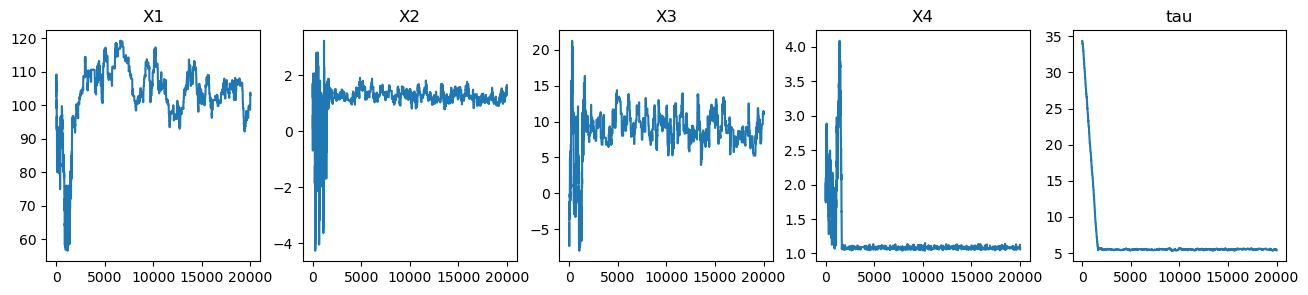

In [42]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
sns.lineplot(samples[:, 0], ax=axs[0]).set_title('X1')
sns.lineplot(samples[:, 1], ax=axs[1]).set_title('X2')
sns.lineplot(samples[:, 2], ax=axs[2]).set_title('X3')
sns.lineplot(samples[:, 3], ax=axs[3]).set_title('X4')
sns.lineplot(samples[:, 4], ax=axs[4]).set_title('tau')

In [38]:
def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model.run(prcp, et)[0]

    nse_score = nse(flow, flow_pred)
    nnse_score = normalize(nse_score)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, flow, label='obs', alpha=0.8)
    ax.plot(dates, flow_pred, label='pred', alpha=1.0)
    ax.plot(dates, prcp, 'g--', label='precip', alpha=0.35)
    ax.plot(dates, et, 'y--', label='etp', alpha=0.35)
    

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

NSE: 0.013
Normalized NSE: 0.503


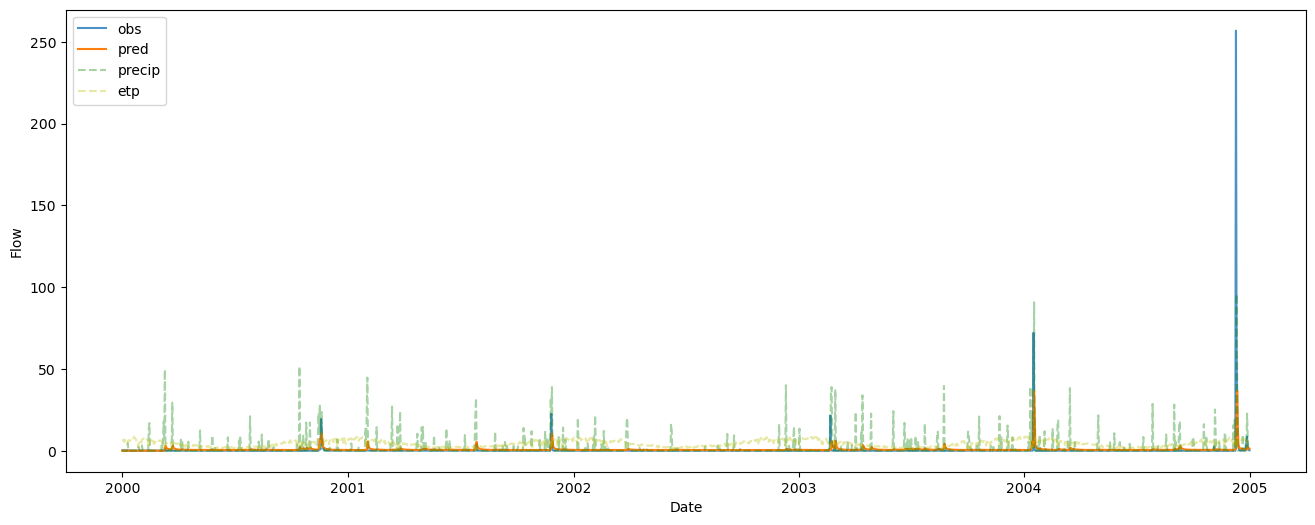

In [39]:
# Evaluate on unseen data
prcp_holdout = holdout_data.loc[:, 'Rain'].values
et_holdout= holdout_data.loc[:, 'FAO56'].values
flow_holdout = holdout_data.loc[:, 'Value'].values
date_holdout = holdout_data.loc[:, 'Date'].values


rw_gr4j.gr4j.update_params(*samples.mean(0)[:-1])

evaluate(rw_gr4j.gr4j, date_holdout,  et_holdout, prcp_holdout, flow_holdout)